In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Data Loading

The paths to the training, validation, and test sets have been specified below.

In [2]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

As we can see, each directory contains two subfolders: fake and real.

In [3]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


# Short EDA - Exploratory Data Analysis

Create a dictionary with three keys:
* **folder**: train, validation and test folders
* **image_path**: path of the images
* **label**: image's label (fake or real)    

In [4]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [5]:
images_df = pd.DataFrame(images_df)

In [6]:
images_df.head()

,folder,image_path,label
0,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
1,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
2,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
3,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
4,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake


### Labels distribution

In [7]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [8]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [9]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

As we can see fromt the results, the labels are equally distributed on each folder.

# Data Preparation for visualization and training

## Data Augmentation

ImageDataGenerator generates batches of tensor image data with real-time data augmentation. Horizontal flip data augmentation is set to True in order to increase the size of a dataset by flipping images horizontally. This can help improve the accuracy of the model by exposing it to additional variations of the same images.

In [10]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

Important! test_ds prediction and train_ds.classes (ground-truth) **will be not alligned** with suffle=True, so I need to disable shuffle for the test set.

In [11]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [12]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

# Data Visualization

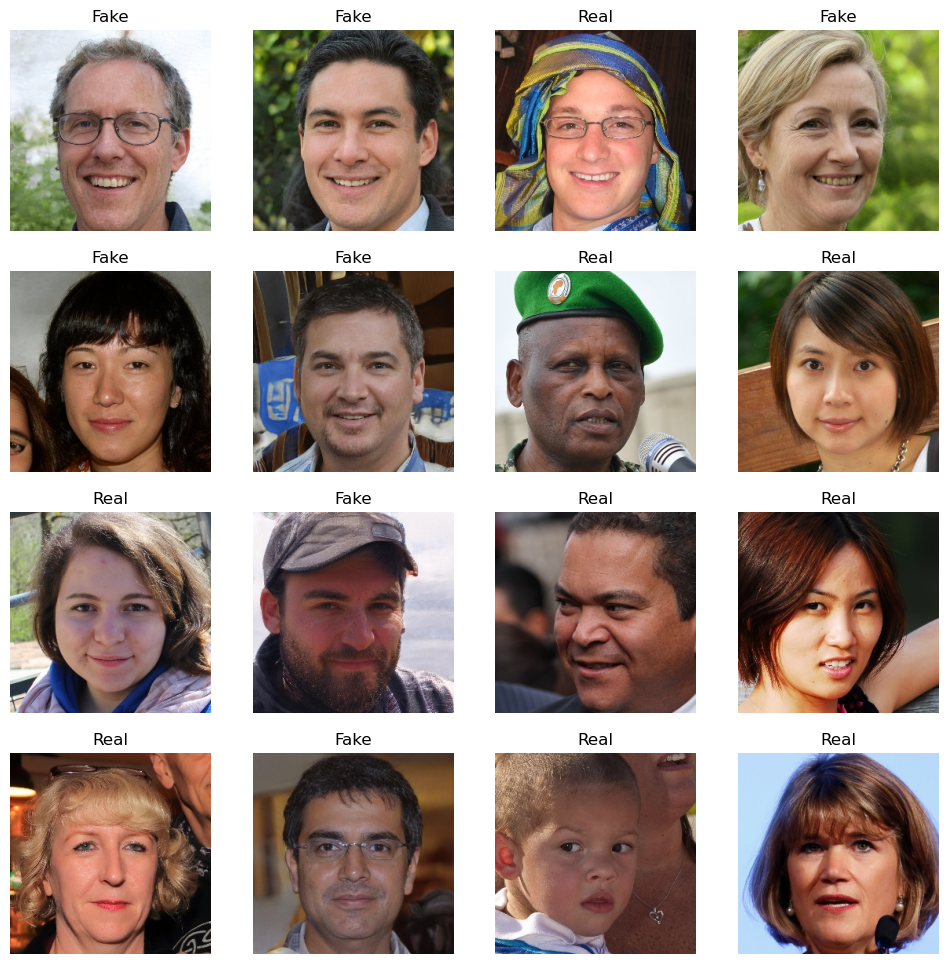

In [13]:
img,lbl = next(train_ds)
plot_images(img,lbl)


It's visible that all the value are scaled.

In [14]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.8862746  0.909804   0.909804  ]
  [0.8980393  0.9215687  0.9215687 ]
  [0.909804   0.9333334  0.9333334 ]
  ...
  [0.86666673 0.91372555 0.9058824 ]
  [0.86666673 0.9058824  0.90196085]
  [0.86274517 0.90196085 0.8980393 ]]

 [[0.8980393  0.9215687  0.9215687 ]
  [0.9058824  0.9294118  0.9294118 ]
  [0.909804   0.9333334  0.9333334 ]
  ...
  [0.86666673 0.91372555 0.9058824 ]
  [0.8705883  0.909804   0.9058824 ]
  [0.86666673 0.9058824  0.90196085]]

 [[0.909804   0.9333334  0.9333334 ]
  [0.909804   0.9333334  0.9333334 ]
  [0.909804   0.9333334  0.9333334 ]
  ...
  [0.86666673 0.91372555 0.9058824 ]
  [0.8705883  0.909804   0.9058824 ]
  [0.86666673 0.9058824  0.90196085]]

 ...

 [[0.17254902 0.1764706  0.19215688]
  [0.08235294 0.09803922 0.10980393]
  [0.22352943 0.25490198 0.2627451 ]
  ...
  [0.4784314  0.48627454 0.5372549 ]
  [0.49411768 0.5019608  0.5529412 ]
  [0.61960787 0.627451   0.6745098 ]]

 [[0.3372549  0.43137258 0.43921572]
  [0.39607847 0.49803925 0.5

Let's print the input shape:
- 32 is the batch size
- 256s are the pixel's values.
- 3 are the channel (rgb)

In [15]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [16]:
train_ds.class_indices

{'fake': 0, 'real': 1}

# CNN 

In [18]:
input_shape = (256, 256, 3) #define the input shape of our data

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

def get_custom_cnn_model(input_shape):
    model = tf.keras.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

# Define the input shape, e.g., (128, 128, 3) for 128x128 color images

custom_cnn_model = get_custom_cnn_model(input_shape)

In [21]:
checkpoint_filepath = "model_cp.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

In [22]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [24]:
history_ft_cnn = custom_cnn_model.fit(train_ds,
                       epochs = 5,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/5
1563/1563 [==============================] - 1277s 810ms/step - loss: 0.4896 - accuracy: 0.7617 - val_loss: 0.7012 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 2/5
1563/1563 [==============================] - 454s 290ms/step - loss: 0.2710 - accuracy: 0.8862 - val_loss: 0.2203 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 3/5
1563/1563 [==============================] - 432s 276ms/step - loss: 0.1854 - accuracy: 0.9259 - val_loss: 0.2065 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 4/5
1563/1563 [==============================] - 436s 279ms/step - loss: 0.1445 - accuracy: 0.9438 - val_loss: 0.1486 - val_accuracy: 0.9392 - lr: 0.0010
Epoch 5/5
1563/1563 [==============================] - 419s 268ms/step - loss: 0.1176 - accuracy: 0.9547 - val_loss: 0.1295 - val_accuracy: 0.9503 - lr: 0.0010


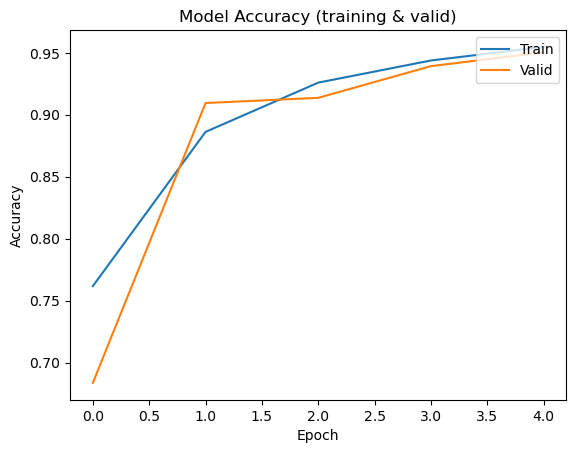

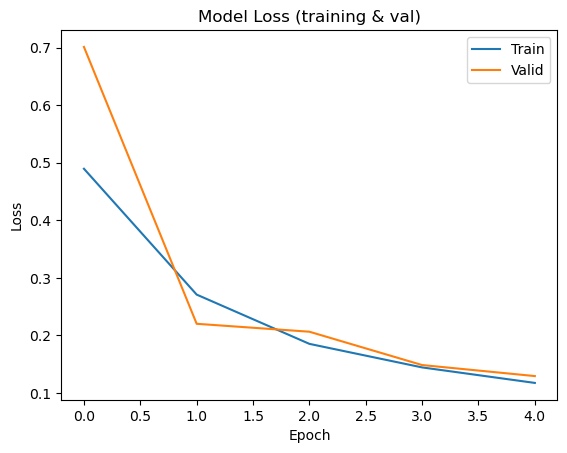

In [25]:
plt.plot(history_ft_cnn.history['accuracy'])
plt.plot(history_ft_cnn.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft_cnn.history['loss'])
plt.plot(history_ft_cnn.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [26]:
# Evaluate the model on the test set
test_loss, test_acc = custom_cnn_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 216s 690ms/step - loss: 0.1296 - accuracy: 0.9510
Test Loss: 0.12959879636764526
Test Accuracy: 0.9509999752044678


1/1 [==============================] - 0s 196ms/step


Text(0.5, 1.0, 'This image is 91.19% Fake and 8.81% Real.')

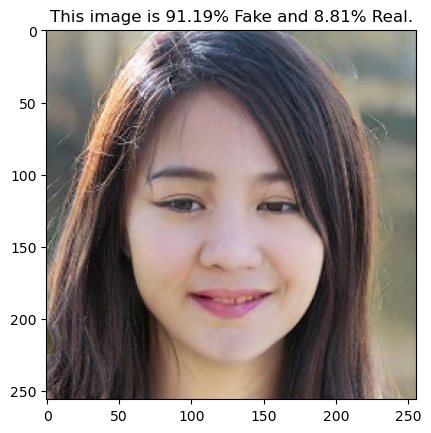

In [27]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = custom_cnn_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


In [28]:
predicted_labels = custom_cnn_model.predict(test_ds)
true_labels = test_ds.classes

313/313 [==============================] - 64s 204ms/step


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels.round())
precision = precision_score(true_labels, predicted_labels.round())
recall = recall_score(true_labels, predicted_labels.round())
f1 = f1_score(true_labels, predicted_labels.round())

# Print the results
print("Confusion Matrix:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
Accuracy: 0.951
Precision: 0.9512707624574744
Recall: 0.9507
F1 Score: 0.9509852955886766


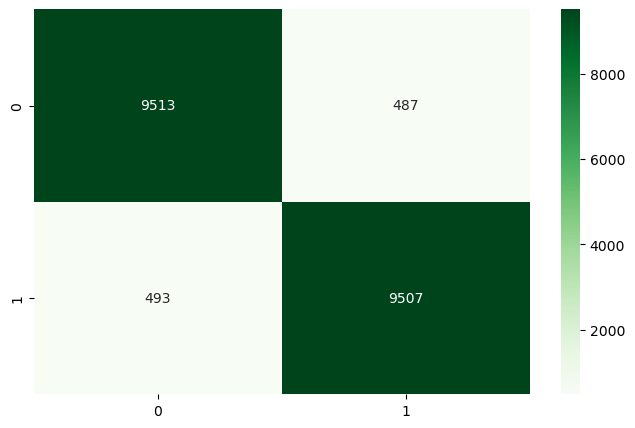

In [30]:
true_labels = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

DENSENET

In [31]:
#create the model's architecture and compile it
def get_densenet_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

densenet_model = get_densenet_model(input_shape)


29084464/29084464 [==============================] - 2s 0us/step


In [32]:
checkpoint_filepath = "model_cp_dense.h5"

checkpoint_cb_dense = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

In [33]:
history_ft_densenet = densenet_model.fit(train_ds,
                       epochs = 5,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb_dense, early_stopping_cb, reduce_lr])

Epoch 1/5
1563/1563 [==============================] - 820s 477ms/step - loss: 0.1333 - accuracy: 0.9452 - val_loss: 0.3725 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 2/5
1563/1563 [==============================] - 736s 471ms/step - loss: 0.0545 - accuracy: 0.9798 - val_loss: 1.3182 - val_accuracy: 0.6666 - lr: 0.0010
Epoch 3/5
1563/1563 [==============================] - 739s 473ms/step - loss: 0.0468 - accuracy: 0.9828 - val_loss: 0.1673 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 4/5
1563/1563 [==============================] - 725s 464ms/step - loss: 0.0347 - accuracy: 0.9873 - val_loss: 1.2012 - val_accuracy: 0.6901 - lr: 0.0010
Epoch 5/5
1563/1563 [==============================] - 723s 463ms/step - loss: 0.0288 - accuracy: 0.9895 - val_loss: 0.2314 - val_accuracy: 0.9145 - lr: 0.0010


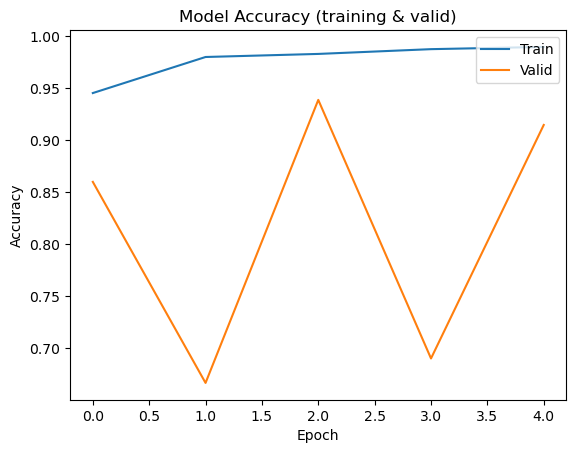

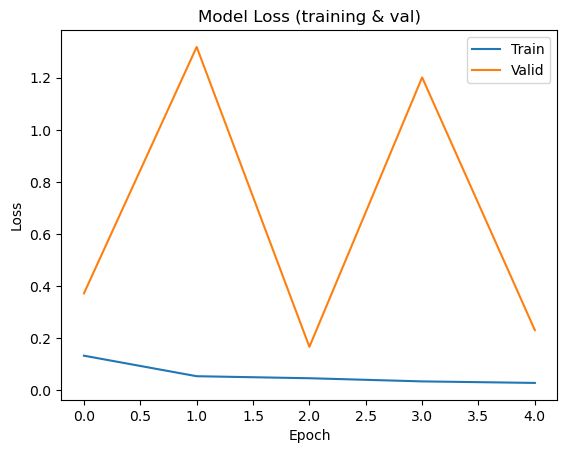

In [34]:
plt.plot(history_ft_densenet.history['accuracy'])
plt.plot(history_ft_densenet.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft_densenet.history['loss'])
plt.plot(history_ft_densenet.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [35]:
# Evaluate the model on the test set
test_loss, test_acc = densenet_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 82s 263ms/step - loss: 0.2286 - accuracy: 0.9160
Test Loss: 0.22860971093177795
Test Accuracy: 0.9160000085830688


1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'This image is 95.88% Fake and 4.12% Real.')

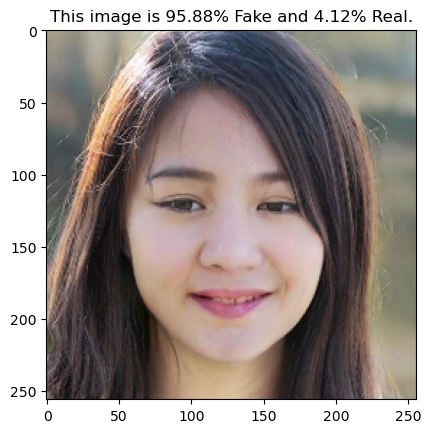

In [36]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = densenet_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


In [37]:
predicted_labels1 = densenet_model.predict(test_ds)
true_labels = test_ds.classes

313/313 [==============================] - 69s 215ms/step


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy1 = accuracy_score(true_labels, predicted_labels1.round())
precision1 = precision_score(true_labels, predicted_labels1.round())
recall1 = recall_score(true_labels, predicted_labels1.round())
f11 = f1_score(true_labels, predicted_labels1.round())

# Print the results
print("Confusion Matrix:")
print("Accuracy:", accuracy1)
print("Precision:", precision1)
print("Recall:", recall1)
print("F1 Score:", f11)

Confusion Matrix:
Accuracy: 0.916
Precision: 0.9950023798191338
Recall: 0.8362
F1 Score: 0.9087154966311672


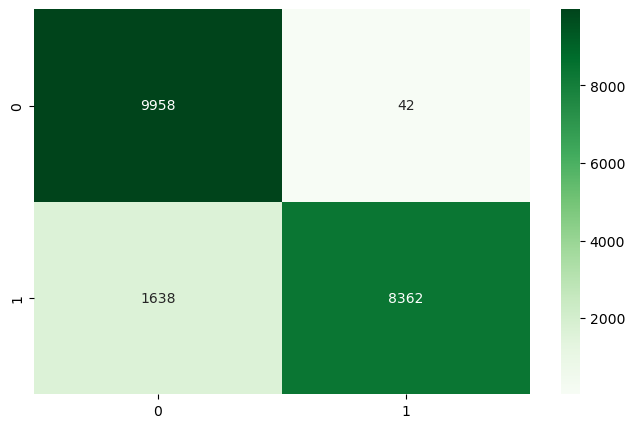

In [39]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels1.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

XCEPTION

In [40]:
#create the model's architecture and compile it
def get_xcp_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    xception = tf.keras.applications.Xception( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(xception.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(xception.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

xcp_model = get_xcp_model(input_shape)

83683744/83683744 [==============================] - 4s 0us/step


In [41]:
checkpoint_filepath = "model_cp_xception.h5"

checkpoint_cb_xception = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

In [42]:
history_ft_xception = xcp_model.fit(train_ds,
                       epochs = 5,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb_xception, early_stopping_cb, reduce_lr])

Epoch 1/5
1563/1563 [==============================] - 1129s 699ms/step - loss: 0.0582 - accuracy: 0.9771 - val_loss: 0.9840 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 2/5
1563/1563 [==============================] - 1083s 693ms/step - loss: 0.0175 - accuracy: 0.9937 - val_loss: 0.0286 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 3/5
1563/1563 [==============================] - 1072s 686ms/step - loss: 0.0129 - accuracy: 0.9955 - val_loss: 6.9983 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/5
1563/1563 [==============================] - 1074s 687ms/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.2167 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 5/5
1563/1563 [==============================] - 1072s 686ms/step - loss: 0.0094 - accuracy: 0.9968 - val_loss: 1.1907 - val_accuracy: 0.7861 - lr: 0.0010


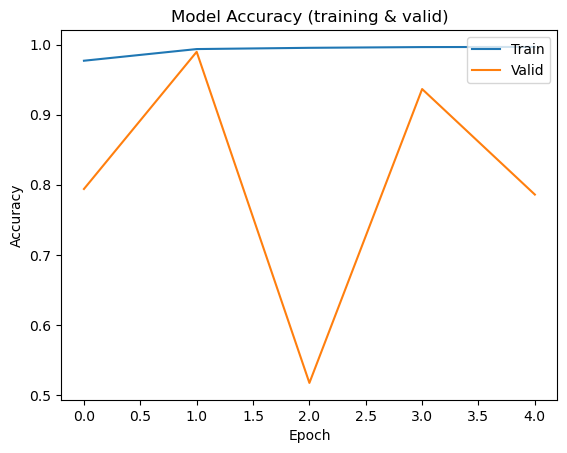

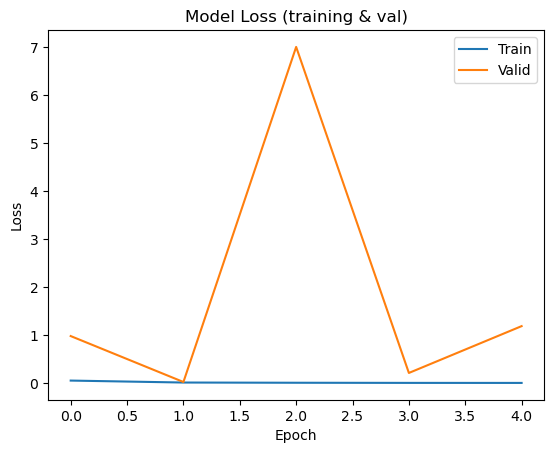

In [43]:
plt.plot(history_ft_xception.history['accuracy'])
plt.plot(history_ft_xception.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft_xception.history['loss'])
plt.plot(history_ft_xception.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [44]:
# Evaluate the model on the test set
test_loss, test_acc = xcp_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 84s 268ms/step - loss: 1.2595 - accuracy: 0.7829
Test Loss: 1.2594627141952515
Test Accuracy: 0.7828500270843506


1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'This image is 100.00% Fake and 0.00% Real.')

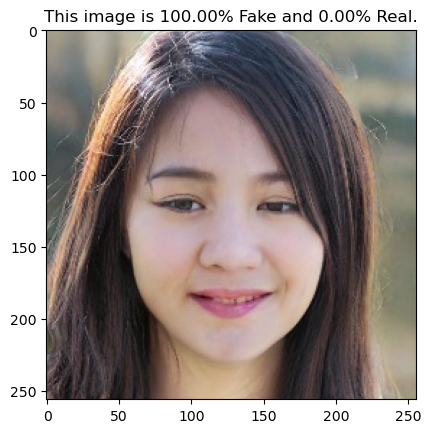

In [45]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = xcp_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


In [46]:
predicted_labels2 = xcp_model.predict(test_ds)
true_labels = test_ds.classes

313/313 [==============================] - 64s 203ms/step


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy2 = accuracy_score(true_labels, predicted_labels2.round())
precision2 = precision_score(true_labels, predicted_labels2.round())
recall2 = recall_score(true_labels, predicted_labels2.round())
f12 = f1_score(true_labels, predicted_labels2.round())

# Print the results
print("Confusion Matrix:")
print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print("F1 Score:", f12)

Confusion Matrix:
Accuracy: 0.78285
Precision: 0.9998232903339813
Recall: 0.5658
F1 Score: 0.7226515103135577


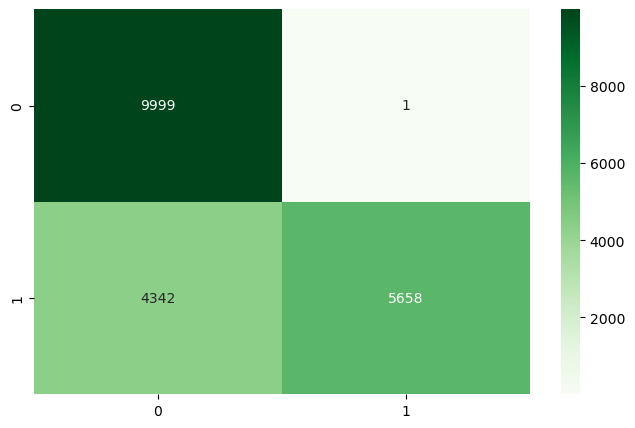

In [48]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels2.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()